# 4D Fast Accurate Fourier Transform
## Complex to Complex

In [1]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import time


In [2]:
%matplotlib inline    


## Loading FFT routines

In [3]:
gridDIM = 64

size = gridDIM**4

axes0 = 0
axes1 = 1
axes2 = 2
axes3 = 3

segment_axes0 = 0
segment_axes1 = 0
segment_axes2 = 0
segment_axes3 = 0

normFactor = 10.0

DIR_BASE = "/home/rcabrera/Documents/source/Python/FFT-dev/FAFT128_C2C/"

# FAFT
_faft128_4D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT128_4D_C2C.so' )
_faft128_4D.FAFT128_4D_C2C.restype = int
_faft128_4D.FAFT128_4D_C2C.argtypes = [ctypes.c_void_p, 
                                         ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                                         ctypes.c_int, ctypes.c_float]

cuda_faft = _faft128_4D.FAFT128_4D_C2C

## Initializing Data

## Gaussian

In [4]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2. , dtype=np.float32 )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p , dtype=np.float32 )*np.exp( - p**2*sigma**2/2. , dtype=np.float32 )

In [5]:
# Gaussian parameters
x_mu = 1.5
x_sigma = 1.

p_x_mu = 1.5
p_x_sigma = 1.

y_mu = 1.
y_sigma = 1.

p_y_mu = 1.
p_y_sigma = 1.

# Grid parameters
x_amplitude = 12
p_x_amplitude = 12.
y_amplitude = 10.
p_y_amplitude = 10.

theta_x_amplitude = 10.
lambda_x_amplitude = 10.
theta_y_amplitude  = 5.           # With the traditional method p amplitude is fixed to: 2 * np.pi /( 2*x_amplitude ) 
lambda_y_amplitude = 5.

# Phase space 
dx    = 2*x_amplitude  /float(gridDIM)  
dp_x  = 2*p_x_amplitude/float(gridDIM)  
dy    = 2*y_amplitude  /float(gridDIM) 
dp_y  = 2*p_y_amplitude/float(gridDIM)

# Conjugate Phase space (Fourier transform)
dtheta_x  = 2*theta_x_amplitude /float(gridDIM) 
dlambda_x = 2*lambda_x_amplitude/float(gridDIM)
dtheta_y  = 2*theta_y_amplitude /float(gridDIM) 
dlambda_y = 2*lambda_y_amplitude/float(gridDIM)

# delta parameters
delta_x  =     dx*dtheta_x/(2*np.pi)
delta_p_x = dp_x*dlambda_x/(2*np.pi)
delta_y  =     dy*dtheta_y/(2*np.pi)
delta_p_y = dp_y*dlambda_y/(2*np.pi)

#
#                       Phase space range
#
x_range   = np.linspace( -x_amplitude,   x_amplitude  -dx,    gridDIM  ) 
p_x_range = np.linspace( -p_x_amplitude, p_x_amplitude-dp_x,  gridDIM  ) 
y_range   = np.linspace( -y_amplitude,   y_amplitude  -dy,    gridDIM  ) 
p_y_range = np.linspace( -p_y_amplitude, p_y_amplitude-dp_y,  gridDIM  ) 

# Conjugate  phase space
theta_x_range  = np.linspace( -theta_x_amplitude,  theta_x_amplitude -dtheta_x,    gridDIM ) 
lambda_x_range = np.linspace( -lambda_x_amplitude, lambda_x_amplitude-dlambda_x,   gridDIM ) 
theta_y_range  = np.linspace( -theta_y_amplitude,  theta_y_amplitude -dtheta_y,    gridDIM ) 
lambda_y_range = np.linspace( -lambda_y_amplitude, lambda_y_amplitude-dlambda_y,   gridDIM ) 

# Grid 
x   =   x_range[ np.newaxis, np.newaxis, np.newaxis, : ] 
p_x = p_x_range[ np.newaxis, np.newaxis, :, np.newaxis ] 
y   =   y_range[ np.newaxis, :, np.newaxis, np.newaxis ] 
p_y = p_y_range[ :, np.newaxis, np.newaxis, np.newaxis ] 


In [6]:
def norm_GPU(W):
    return gpuarray.sum(W).real.get()*dx*dy*dp_x*dp_y

In [7]:
f = Gaussian(x,x_mu,x_sigma)*Gaussian(y,y_mu,y_sigma)*Gaussian(p_x,p_x_mu, p_x_sigma)*Gaussian(p_y,p_y_mu,p_y_sigma)

#f = f + 1j*np.zeros_like(f)
f = f + 0j

print ' Amplitude x = ',  x_amplitude
print ' Amplitude p_x = ',p_x_amplitude
print '        '

print 'x_mu = ', x_mu
print 'y_mu = ', y_mu
print 'p_x_mu = ', p_x_mu
print 'p_y_mu = ', p_y_mu

print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp_x    = ', dp_x
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta_x = ', delta_x


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f.real)


 Amplitude x =  12
 Amplitude p_x =  12.0
        
mu_x =  1.5
mu_y =  1.0
p_x_mu =  1.5
p_y_mu =  1.0
   
n     =  64
dx    =  0.375
dp_x    =  0.375
           standard fft dp =  0.261799387799      
    
delta_x =  0.0186509698936
    
The Gaussian extends to the numerical error in single precision:
    min =  0.0


max-min =  0.0093185    0.0


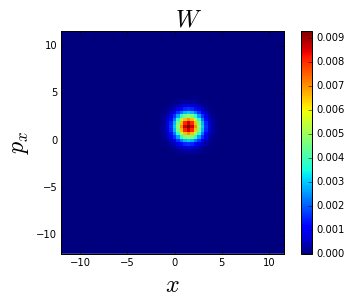

In [8]:
plt.imshow( f[ gridDIM/2, gridDIM/2 , :, :].real, 
           extent=[-x_amplitude , x_amplitude-dx, -p_x_amplitude , p_x_amplitude-dp_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 12.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$p_x$',**axis_font)

plt.colorbar()

print 'max-min = ', f[ gridDIM/2, gridDIM/2 , :, :].real.max(), '  ', f[ gridDIM/2, gridDIM/2 , :, :].real.min()

max-min =  0.00265939    0.0


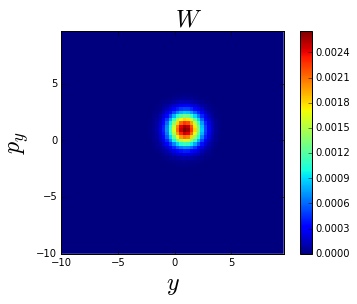

In [9]:
plt.imshow( f[::,::,gridDIM/2, gridDIM/2 ].real, 
           extent=[-y_amplitude , y_amplitude-dx, -p_y_amplitude , p_y_amplitude-dp_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 10.1, '$W$' , **axis_font)
plt.xlabel('$y$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

plt.colorbar()

print 'max-min = ', f[::,::,gridDIM/2, gridDIM/2 ].real.max(), '  ', f[::,::,gridDIM/2, gridDIM/2 ].real.min()

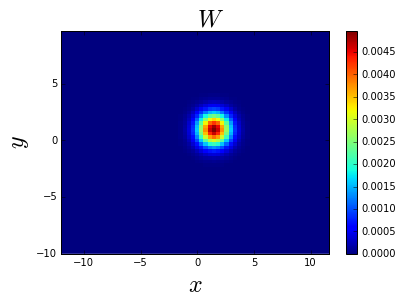

In [10]:
plt.imshow( f[ gridDIM/2 , :: , gridDIM/2 , :: ].real, 
           extent=[-x_amplitude , x_amplitude-dx, -y_amplitude , y_amplitude-dy] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 10.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$y$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

## $W$ TRANSFORM

In [11]:
print '         GPU memory Total (before)      ', pycuda.driver.mem_get_info()[1]/float(2**30) , 'GB'
print '         GPU memory Free  (before)      ', pycuda.driver.mem_get_info()[0]/float(2**30) , 'GB'

F_gpu = gpuarray.zeros( ( gridDIM, gridDIM, gridDIM, gridDIM ), dtype=np.complex64 )

F_gpu[:,:,:,:] = f[:,:,:,:]

print '         GPU memory Total (after)      ', pycuda.driver.mem_get_info()[1]/float(2**30) , 'GB'
print '         GPU memory Free  (after)      ', pycuda.driver.mem_get_info()[0]/float(2**30) , 'GB'

         GPU memory Total (before)       5.1767578125 GB
         GPU memory Free  (before)       4.58404541016 GB
         GPU memory Total (after)       5.1767578125 GB
         GPU memory Free  (after)       4.45806884766 GB


In [12]:
F_gpu.shape

(64, 64, 64, 64)

In [13]:
print 'deltas = ', delta_p_x, delta_x, delta_p_y, delta_y

deltas =  0.0186509698936 0.0186509698936 0.00777123745566 0.00777123745566


### Forward Transform

In [14]:
# Executing FFT
t_init = time.time() 

cuda_faft( int(F_gpu.gpudata), dp_x, delta_p_x, segment_axes0, axes0, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, delta_x, segment_axes1, axes1, normFactor )
cuda_faft( int(F_gpu.gpudata), dp_y, delta_p_y, segment_axes2, axes2, normFactor )
cuda_faft( int(F_gpu.gpudata), dy, delta_y, segment_axes3, axes3, normFactor )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  0.41027712822


In [18]:
# Arbitrary normalization 
F_gpu /= size

### Real Parts

max-min =  0.0093185    0.0


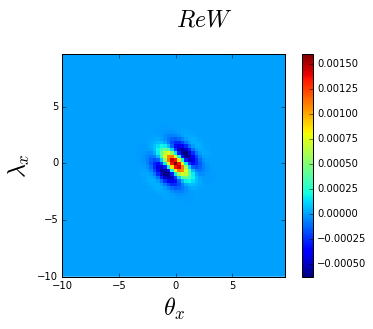

In [19]:
plt.imshow( F_gpu.get()[ gridDIM/2, gridDIM/2 , :, :].real, 
           extent=[-theta_x_amplitude , theta_x_amplitude  - dtheta_x,
                   -lambda_x_amplitude, lambda_x_amplitude - dlambda_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 12.1, '$Re W$' , **axis_font)
plt.xlabel('$\\theta_x$',**axis_font)
plt.ylabel('$\\lambda_x$',**axis_font)

plt.colorbar()

print 'max-min = ', f[ gridDIM/2, gridDIM/2 , :, :].real.max(), '  ', f[ gridDIM/2, gridDIM/2 , :, :].real.min()

max-min =  0.0093185    0.0


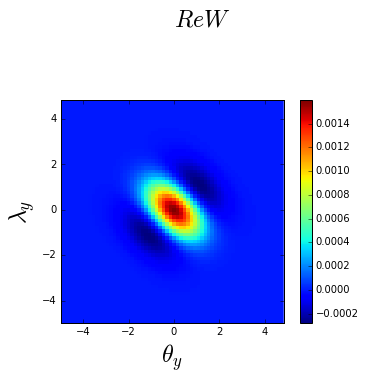

In [20]:
plt.imshow( F_gpu.get()[ :,:,gridDIM/2, gridDIM/2 ].real, 
           extent=[-theta_y_amplitude , theta_y_amplitude  - dtheta_y,
                   -lambda_y_amplitude, lambda_y_amplitude - dlambda_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 8.1, '$Re W$' , **axis_font)
plt.xlabel('$\\theta_y$',**axis_font)
plt.ylabel('$\\lambda_y$',**axis_font)

plt.colorbar()

print 'max-min = ', f[ gridDIM/2, gridDIM/2 , :, :].real.max(), '  ', f[ gridDIM/2, gridDIM/2 , :, :].real.min()

### Imaginary Parts

max-min =  0.0093185    0.0


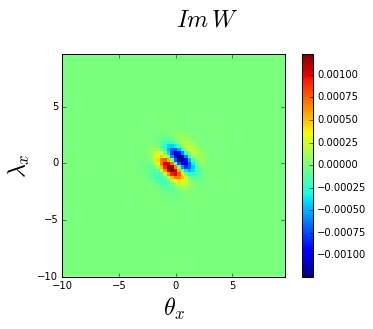

In [21]:
plt.imshow( F_gpu.get()[ gridDIM/2, gridDIM/2 , :, :].imag, 
           extent=[-theta_x_amplitude , theta_x_amplitude  - dtheta_x,
                   -lambda_x_amplitude, lambda_x_amplitude - dlambda_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 12.1, '$Im\,W$' , **axis_font)
plt.xlabel('$\\theta_x$',**axis_font)
plt.ylabel('$\\lambda_x$',**axis_font)

plt.colorbar()

print 'max-min = ', f[ gridDIM/2, gridDIM/2 , :, :].real.max(), '  ', f[ gridDIM/2, gridDIM/2 , :, :].real.min()

max-min =  0.0093185    0.0


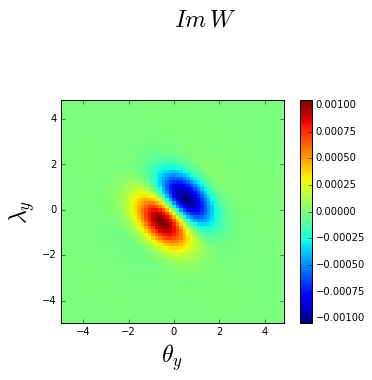

In [22]:
plt.imshow( F_gpu.get()[ :,:,gridDIM/2, gridDIM/2 ].imag, 
           extent=[-theta_y_amplitude , theta_y_amplitude  - dtheta_y,
                   -lambda_y_amplitude, lambda_y_amplitude - dlambda_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 8.1, '$Im\,W$' , **axis_font)
plt.xlabel('$\\theta_y$',**axis_font)
plt.ylabel('$\\lambda_y$',**axis_font)

plt.colorbar()

print 'max-min = ', f[ gridDIM/2, gridDIM/2 , :, :].real.max(), '  ', f[ gridDIM/2, gridDIM/2 , :, :].real.min()

# Inverse

In [23]:
# Executing iFFT
t_init = time.time() 

cuda_faft( int(F_gpu.gpudata), dp_x, -delta_p_x, segment_axes0, axes0, normFactor )
cuda_faft( int(F_gpu.gpudata), dx, -delta_x, segment_axes1, axes1, normFactor )
cuda_faft( int(F_gpu.gpudata), dp_y, -delta_p_y, segment_axes2, axes2, normFactor )
cuda_faft( int(F_gpu.gpudata), dy, -delta_y, segment_axes3, axes3, normFactor )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  0.445533037186


In [27]:
norm = norm_GPU(F_gpu)
F_gpu /= norm

max-min =  0.0093185    0.0


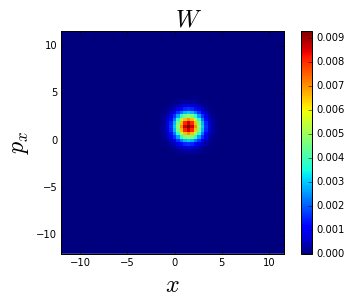

In [28]:
plt.imshow( F_gpu.get()[ gridDIM/2, gridDIM/2 , :, :].real, 
           extent=[-x_amplitude , x_amplitude-dx, -p_x_amplitude , p_x_amplitude-dp_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 12.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$p_x$',**axis_font)

plt.colorbar()

print 'max-min = ', f[ gridDIM/2, gridDIM/2 , :, :].real.max(), '  ', f[ gridDIM/2, gridDIM/2 , :, :].real.min()

max-min =  0.00265939    0.0


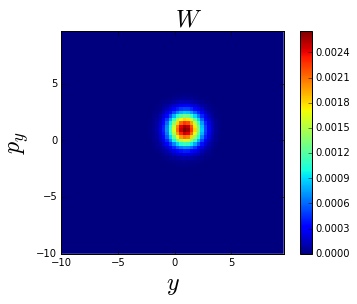

In [29]:
plt.imshow( F_gpu.get()[::,::,gridDIM/2, gridDIM/2 ].real, 
           extent=[-y_amplitude , y_amplitude-dx, -p_y_amplitude , p_y_amplitude-dp_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 10.1, '$W$' , **axis_font)
plt.xlabel('$y$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

plt.colorbar()

print 'max-min = ', f[::,::,gridDIM/2, gridDIM/2 ].real.max(), '  ', f[::,::,gridDIM/2, gridDIM/2 ].real.min()

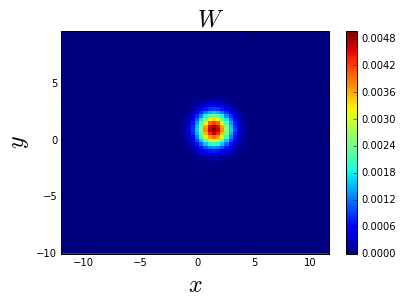

In [30]:
plt.imshow( F_gpu.get()[ gridDIM/2 , :: , gridDIM/2 , :: ].real, 
           extent=[-x_amplitude , x_amplitude-dx, -y_amplitude , y_amplitude-dy] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 10.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$y$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

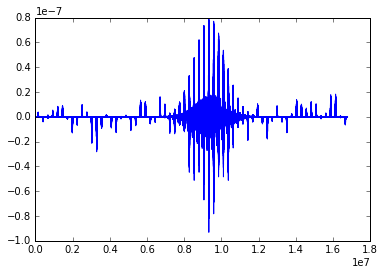

In [46]:
# Comparing with the original 
plt.plot(
( F_gpu.get() - f  ).flatten().real )